In [1]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 51.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 56.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 KB 3.3 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
import cv2
cv2.__version__

'4.5.4'

In [39]:
from PIL import Image

import napari
import scipy
import csv
import imghdr
import colorsys
import os
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt

import pyvista as pv

from csbdeep.utils import normalize
from scipy import ndimage as ndi

from skimage import filters
from skimage.draw import disk
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops
from skimage.filters import threshold_local

# from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html
from IPython.display import clear_output

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

from sklearn.svm import OneClassSVM

from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.morphology import closing, square

from napari.settings import get_settings
settings = get_settings()

from aicsimageio import AICSImage
from tifffile import imwrite

In [40]:
def ellipse_pixels(center, semi_axes, rotation, image_shape):
    y, x = np.meshgrid(np.arange(imarray.shape[1]), np.arange(imarray.shape[0]), indexing='xy')
    cos_theta = np.cos(rotation)
    sin_theta = np.sin(rotation)
    
    x_rot = cos_theta * (x - center[0]) + sin_theta * (y - center[1])
    y_rot = -sin_theta * (x - center[0]) + cos_theta * (y - center[1])

    mask = (x_rot / semi_axes[0])**2 + (y_rot / semi_axes[1])**2 <= 1

    settings.application.ipy_interactive = True

    return np.column_stack(np.where(mask))

def rgb_to_hsv(rgb_array):
    hsv_list = []
    for rgb in rgb_array:
        r, g, b = rgb  # Extract the components
        h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert to HSV
        hsv_list.append([h * 360, s * 100, v * 100])  # Scale H to degrees, S and V to percentages
    return np.array(hsv_list)

def csv_to_matrix(file_path):
    matrix = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            matrix.append([int(value) if value.replace('.', '', 1).isdigit() else value for value in row])
    return matrix

def classify_points(cloud_points, test_points, bandwidth=1.0):
    # Fit a Kernel Density Estimator to the cloud points
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(cloud_points)
    
    # Evaluate the probability density for each test point
    log_density = kde.score_samples(test_points)
    
    # Convert log-density to probabilities
    probabilities = np.exp(log_density)
    return probabilities

## File upload
Write the name of the file that needs to be investigated.

In [41]:
tiff_file='10Xcow1_TNF3.tif'
tiff_stem=os.path.splitext(os.path.basename(tiff_file))[0]

img=Image.open(tiff_file)
imarray=np.array(img)
print(imarray.shape)

(4503, 4503, 3)


In [67]:
r_X=0.698 #um, 10X
r_Y=0.698 #um, 10X

## ROI 
This section will find the region of interest by checking the blue part. 

#### If the image is RGBA and we only want RGB, remove A channel

In [43]:
# Remove alpha channel if present
if imarray.shape[2] == 4:
    imarray = imarray[:, :, :3]

Variables: [step] will dictate the size of the square of investigation (smaller values will get a better resolution but slower run), [delta] will dictate the sensitivity of the blue level (smaller values lead to more false positive but higher values lead to more false negative).  

In [44]:
ROI_image = imarray.copy()

mask_image = np.zeros(np.shape(imarray[:, :, 1]))
step = 30
delta = 1
holes_threshold = 1000
island_threshold = 1000

for i in range(1 + step, imarray.shape[0], step):
    for j in range(1 + step, imarray.shape[1], step):
        # Ensure blue is dominant over both red and green
        if (
            np.mean(ROI_image[i-step:i+step, j-step:j+step, 2]) >= delta + np.mean(ROI_image[i-step:i+step, j-step:j+step, 1]) and
            np.mean(ROI_image[i-step:i+step, j-step:j+step, 2]) >= delta + np.mean(ROI_image[i-step:i+step, j-step:j+step, 0])
        ):
            mask_image[i:i+step, j:j+step] = 1

mask_filled = remove_small_holes(mask_image.astype(int), area_threshold=holes_threshold, connectivity=1)
mask_filled = remove_small_objects(mask_filled, min_size=island_threshold, connectivity=1)

ROI_image = imarray * np.stack([mask_filled] * 3, axis=2)


1399042084.py (18): Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [45]:
settings.application.ipy_interactive = True

viewer_0 = napari.Viewer()

viewer_0.add_image(imarray, name='Original', 
                colormap='grey', blending='additive')
viewer_0.add_image(mask_filled, name='Violet', 
                colormap='green', blending='additive')

<Image layer 'Violet' at 0x7bc86546ef80>

### Training image
Choose the image that will be used as training. It will be opened in Napari. Choose the circular selection on the right and choose as many nuclei as possible to train the algorithm. Then close the Napari window to continue

In [46]:
training_file='10Xcow1_IL1_4_zoom.tif'
training_stem=os.path.splitext(os.path.basename(training_file))[0]

#training_img=Image.open(training_file)
#trainarray=np.array(training_img)

use_csv=True

if use_csv and os.path.exists(training_stem+'_yes_points.csv'):
    yes_points = csv_to_matrix(training_stem+'_yes_points.csv')
else:
    yes_points=[]
    
    ROI_labels=np.zeros(trainarray.shape)
    
    settings.application.ipy_interactive = False
    
    viewer_c = napari.Viewer()
    
    viewer_c.add_image(trainarray, name='Original', 
                colormap='grey', blending='additive')
    
    def on_shape_added(layer, event):
        shapes_layer= event.source
    
    shapes_layer = viewer_c.add_shapes(shape_type="circle", name="Nuclei training")
    
    # Connect the click event to our callback function
    viewer_c.mouse_drag_callbacks.append(on_shape_added)
    
    napari.run()

    for s in range(0,np.shape(shapes_layer.data)[0]):
        xmax=np.max(shapes_layer.data[s][:,0])
        ymax=np.max(shapes_layer.data[s][:,1])
        xmin=np.min(shapes_layer.data[s][:,0])
        ymin=np.min(shapes_layer.data[s][:,1])
        #print(shapes_layer.data)
    
        # Calculate ellipse parameters
        center = ((xmax + xmin) / 2, (ymax + ymin) / 2)
        semi_axes = (
            abs(xmax - xmin) / 2,  # Semi-major axis (height / 2)
            abs(ymax - ymin) / 2,  # Semi-minor axis (width / 2)
        )
        rotation = 0  # Napari's ellipses are axis-aligned by default
    
        image_shape=trainarray.shape
    
        # Get the pixel coordinates inside the ellipse
        enclosed_pixels = ellipse_pixels(center, semi_axes, rotation, image_shape[:2])
    
        #print(enclosed_pixels)

        if os.path.exists(training_stem+'_yes_points.csv'):
            yes_points = csv_to_matrix(training_stem+'_yes_points.csv')
    
        for i in range(enclosed_pixels.shape[0]):
            x=enclosed_pixels[i][0]
            y=enclosed_pixels[i][1]
            #print(new_point)
            yes_points.append([trainarray[x,y,0],trainarray[x,y,1],trainarray[x,y,2]])

        with open(training_stem+'_yes_points.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(yes_points)

yes_points=np.array(yes_points)

Text(0, 0.5, 'BLUE')

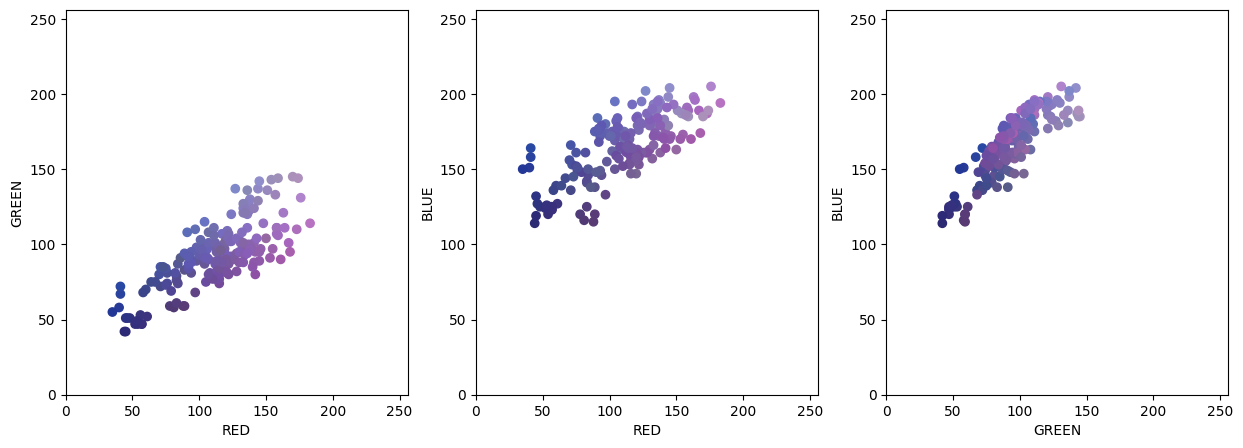

In [47]:
## Visualize distribution of training points

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(yes_points[:,0],yes_points[:,1], c = yes_points/255)
axs[0].set_xlim((0,256))
axs[0].set_xlabel("RED")
axs[0].set_ylim((0,256))
axs[0].set_ylabel("GREEN")
axs[1].scatter(yes_points[:,0],yes_points[:,2], c = yes_points/255)
axs[1].set_xlim((0,256))
axs[1].set_xlabel("RED")
axs[1].set_ylim((0,256))
axs[1].set_ylabel("BLUE")
axs[2].scatter(yes_points[:,1],yes_points[:,2], c = yes_points/255)
axs[2].set_xlim((0,256))
axs[2].set_xlabel("GREEN")
axs[2].set_ylim((0,256))
axs[2].set_ylabel("BLUE")

After you run the next section, a new Napari window will appear with highlighted in green all the nuclei in the ROI.

In [48]:
settings.application.ipy_interactive = True

imarray0=ROI_image.copy()

imR=imarray0[:,:,0]
imG=imarray0[:,:,1]
imB=imarray0[:,:,2]

yes_points_hsv=rgb_to_hsv(yes_points)

scaler = StandardScaler()
yes_points_scaled = scaler.fit_transform(yes_points_hsv)

sensitivity = 0.7  # Choose sensitivity level (e.g., 10% of points allowed as outliers)
clf = OneClassSVM(kernel='rbf', nu=sensitivity, gamma='scale')
clf.fit(yes_points_scaled)

imV=np.zeros(np.shape(imR))
tval=0
for i in range(step,np.shape(imV)[0]):
    for j in range(step,np.shape(imV)[1]):
        tval+=1
        #print(pR)
        if (mask_filled[i,j]>0):
            pR=imR[i,j]
            pG=imG[i,j]
            pB=imB[i,j]
            X = np.array([
                [pR, pG, pB]
            ])
            #print(X)
            X_hsv = rgb_to_hsv(X)
            X_scaled = scaler.transform(X_hsv)
            #print(X_scaled)
            predictions = classify_points(yes_points, X, bandwidth=20.0)
            #print(predictions)
            if predictions>0.0:
                imV[i,j]=predictions[0]
                #yes_points=np.append(yes_points,X,axis=0)
            else:
                imV[i,j]=0
                #no_points=np.append(no_points,X,axis=0)
        else:
            j+=step

        if (100.0*tval/(np.shape(imV)[0]*np.shape(imV)[1])%1.0==0.0):
            clear_output(wait=True)
            print('PROGRESS ' + str(100.0*tval/(np.shape(imV)[0]*np.shape(imV)[1])) + ' %')

viewer_0 = napari.Viewer()

viewer_0.add_image(imarray0, name='ROI', 
                colormap='grey', blending='additive')
viewer_0.add_image(imV, name='Violet', 
                colormap='green', blending='additive')

<Image layer 'Violet' at 0x7bc86522bb20>

#### Remove noise and big regions

In [49]:
# Get all nonzero values in imV (ignoring background)
valid_pixels = imV[imV > 0]  

# Compute the 98th percentile threshold only for these valid pixels
if len(valid_pixels) > 0:  # Ensure there are nonzero pixels
    threshold_value = np.percentile(valid_pixels, 99.5)  
    binary_mask = (imV >= threshold_value)  # Keep only the top 2% brightest pixels
else:
    binary_mask = np.zeros_like(imV)  # If no valid pixels, return empty mask

# Visualization
viewer_1 = napari.Viewer()
viewer_1.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_1.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_1.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_1.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")

napari.run()

In [50]:
# Step 2: Remove Noise & Artifacts
binary_mask2 = remove_small_objects(binary_mask, min_size=5)  
binary_mask2 = closing(binary_mask2, square(3))  # Fills small holes and connects nearby white regions.

# Visualization
viewer_2 = napari.Viewer()
viewer_2.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_2.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_2.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_2.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_2.add_image(binary_mask2.astype(float), name="Noise_removed", colormap="blue", blending="additive")

napari.run()

In [51]:
# Step 3: Remove Artifacts Based on Size
min_nucleus_size = 1  
max_nucleus_size = 130  
filtered_mask = np.zeros_like(binary_mask2)

for region in regionprops(label(binary_mask2)):
    if min_nucleus_size <= region.area <= max_nucleus_size:
        filtered_mask[label(binary_mask2) == region.label] = 1  

# Visualization
viewer_3 = napari.Viewer()
viewer_3.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_3.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_3.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_3.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_3.add_image(binary_mask2.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_3.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")

napari.run()

In [52]:
# Step 4: Watershed for Better Separation
distance = distance_transform_edt(filtered_mask)  
markers = label(distance > 0.0001 * distance.max())  
segmented_nuclei = watershed(-distance, markers, mask=filtered_mask)  

# Visualization
viewer_4 = napari.Viewer()
viewer_4.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_4.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_4.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_4.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_4.add_image(filtered_mask.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_4.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")
viewer_4.add_labels(segmented_nuclei, name="Segmented Nuclei")
napari.run()


In [58]:
#🔹 Step 5: Filter by Roundness (Elongation Ratio)

max_ratio = 3.0  # Maximum allowed elongation ratio (major_axis / minor_axis)
filtered_segments = np.zeros_like(segmented_nuclei)  # Empty mask for valid segments

k=1
for region in regionprops(segmented_nuclei):
    if region.minor_axis_length > 0:  # Avoid division by zero
        elongation_ratio = region.major_axis_length / region.minor_axis_length  
        if elongation_ratio <= max_ratio:  # Keep only segments with acceptable roundness
            filtered_segments[segmented_nuclei == region.label] = k
            k+=1

# Visualization
viewer_5 = napari.Viewer()
viewer_5.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_5.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_5.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_5.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_5.add_image(filtered_mask.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_5.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")
viewer_5.add_labels(segmented_nuclei, name="Segmented Nuclei")
viewer_5.add_labels(filtered_segments, name="Filtered by Roundness")
napari.run()

### Output 
Creates a .tiff file with multiple pages. P1 is the original image, P2 is the ROI chosen as the tissue, P3 is the detected nuclei.

In [59]:
# Convert images to RGB
rgb_im = Image.fromarray(imarray.astype(np.uint8), mode="RGB")
rgb0_im = Image.fromarray(imarray0.astype(np.uint8), mode="RGB")

#filtered_segments = filtered_segments.astype(np.uint8)  # Ensure uint8 format
filtered_segments_rgb=np.zeros((np.shape(filtered_segments)[0],np.shape(filtered_segments)[1],3))

cmd=np.random.rand(np.max(filtered_segments)+1,3)
cmd[0,:]=[0.0,0.0,0.0]

#filtered_segments_normalized = filtered_segments / filtered_segments.max()  # Normalize
for i in range(1,np.shape(filtered_segments)[0]):
    for j in range(1,np.shape(filtered_segments)[1]):
        filtered_segments_rgb[i,j,0] = int(cmd[filtered_segments[i,j],0] * 255.0)
        filtered_segments_rgb[i,j,1] = int(cmd[filtered_segments[i,j],1] * 255.0)
        filtered_segments_rgb[i,j,2] = int(cmd[filtered_segments[i,j],2] * 255.0)
# Set background pixels (where filtered_segments is 0) to white
#filtered_segments_rgb[filtered_segments == 0] = [255, 255, 255]

filtered_segments_rgb=filtered_segments_rgb.astype('uint8')

b_im = Image.fromarray(filtered_segments_rgb, mode="RGB") 


# Save both images in a single TIFF file
output_path = tiff_stem+"_output.tiff"
rgb_im.save(output_path, save_all=True, append_images=[rgb0_im,b_im])

print(f"TIFF file saved at: {output_path}")

TIFF file saved at: 10Xcow1_TNF3_output.tiff


### QUANTIFICATION

In [76]:
from scipy.ndimage import label, center_of_mass

labels = np.unique(filtered_segments)
labels = labels[labels != 0]

print('TOTAL NUCLEI ' + str(len(labels+1)))

# Compute centroids
barycenters = {label: center_of_mass(filtered_segments == label) for label in labels}
areas={label: np.sum(filtered_segments == label)*r_X*r_Y for label in labels}

# Convert to list of coordinates
barycenter_coords = {k: (round(v[0], 2)*r_X, round(v[1], 2)*r_Y) for k, v in barycenters.items()}

#Total Area ROI
fullA=np.prod(np.shape(mask_image))*r_X*r_Y
roiA=np.sum(mask_image)*r_X*r_Y
print("TOTAL AREA IMAGE %.2e um2" %fullA)
print("TOTAL AREA ROI %.2e um2" %roiA)

#Concentration cells in ROI
roiCON=(len(labels+1))/roiA
print("CELL CONCENTRATION in ROI %.2e cells/um2" %roiCON)

TOTAL NUCLEI 453
TOTAL AREA IMAGE 9.88e+06 um2
TOTAL AREA ROI 2.89e+06 um2
CELL CONCENTRATION in ROI 1.57e-04 cells/um2


In [82]:
workbook=xlsxwriter.Workbook(tiff_stem+'.xlsx')

## FORMATS
header=workbook.add_format({'bold':True})
header.set_bg_color('yellow')
floats=workbook.add_format({'num_format':'0.00'})
exp=workbook.add_format()
exp.set_num_format(11)

## CELLS
worksheet_cell=workbook.add_worksheet('Cells')

#HEADER
worksheet_cell.write_row('A1:E1',['#ID','X [um]','Y [um]','Area Nuclei [um2]'],header)
    
#CONTENT
for row,value in enumerate(labels):
    worksheet_cell.write(row+1,0,value)
    worksheet_cell.write(row+1,1,barycenter_coords[value][0],floats)
    worksheet_cell.write(row+1,2,barycenter_coords[value][1],floats)
    worksheet_cell.write(row+1,3,areas[value],floats)
    clear_output(wait=True)
    print('NUCLEI ' + str(row+1) + ' / ' + str(len(labels+1)))

## ROI SHEET
worksheet_ROI=workbook.add_worksheet('ROI')

#HEADER
worksheet_ROI.write_row('A1:E1',['# NUCLEI','TOT AREA [um2]','ROI AREA [um2]','CONC NUCLEI in ROI [cells/um2]'],header)
    
#CONTENT

worksheet_ROI.write(1,0,len(labels+1))
worksheet_ROI.write(1,1,fullA,exp)
worksheet_ROI.write(1,2,roiA,exp)
worksheet_ROI.write(1,3,roiCON,exp)

workbook.close()

NUCLEI 453 / 453
